In [48]:
import torch
from torch import nn

# Making the Data

In [49]:
from sklearn.datasets import make_circles

X, y = make_circles(
    n_samples = 1000,
    noise = 0.04,
    random_state = 42
)

In [50]:
X[:10], y[:10]

(array([[ 0.74822656,  0.23908325],
        [-0.74509559,  0.16097526],
        [-0.82262532,  0.19762051],
        [-0.41143316,  0.68255648],
        [ 0.44390494, -0.89582949],
        [-0.47476593,  0.69223611],
        [-0.01484687,  0.80448601],
        [ 0.76556811,  0.15364287],
        [-0.17250712, -0.79664632],
        [-0.11605096,  1.03185826]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

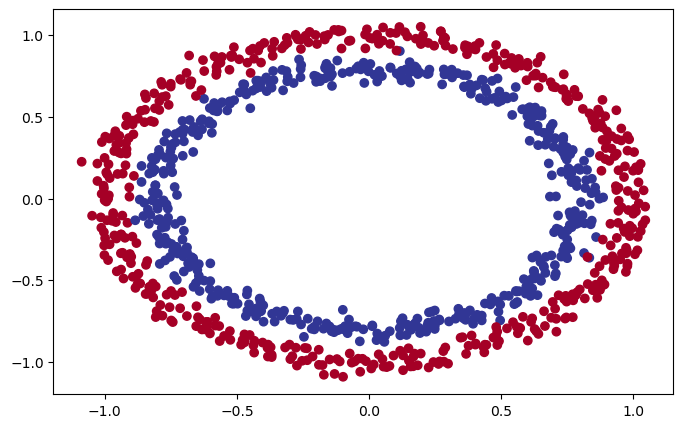

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750,), (250, 2), (250,))

# Setting up device Agnostic code

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Constructing a Linear model

## Linear Model Definition

In [55]:
class CircleModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()
    self.linear_layer1 = nn.Linear(in_features=in_features, out_features=hidden_units)
    self.linear_layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    self.linear_layer3 = nn.Linear(in_features=hidden_units, out_features=out_features)

  def forward(self, x):
    return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))

In [56]:
MANUAL_SEED = 42
torch.manual_seed(42)

model_0 = CircleModel(2, 1, 8).to(device)

In [57]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [58]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
         [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
         [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
         [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
         [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218],
         [ 0.1083, -0.0737,  0.2932, -0.2096, -0.2109, -0.2109,  0.3180,  0.1178],
         [ 0.3402, -0.2918, -0.350

In [59]:
model_0

CircleModel(
  (linear_layer1): Linear(in_features=2, out_features=8, bias=True)
  (linear_layer2): Linear(in_features=8, out_features=8, bias=True)
  (linear_layer3): Linear(in_features=8, out_features=1, bias=True)
)

## PreTrain test

In [60]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [61]:
X_train[:5], y_train[:5]

(tensor([[-0.9012, -0.3958],
         [ 0.1537,  0.8346],
         [-0.3178, -0.9117],
         [-0.6978,  0.4216],
         [-0.8020, -0.0307]], device='cuda:0'),
 tensor([0., 1., 0., 1., 1.], device='cuda:0'))

In [62]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)
y_logits[:5]    # Wx

tensor([[-0.0554],
        [-0.1729],
        [ 0.0884],
        [-0.0989],
        [-0.1507]], device='cuda:0')

In [63]:
y_preds = torch.round(torch.sigmoid(y_logits.squeeze()))  # y_logits(Wx) -> y_pred_probs(sigmoid) -> y_preds(round)
y_preds[:5]

tensor([0., 0., 1., 0., 0.], device='cuda:0')

In [64]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

## Training and Testing the Model

In [65]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [66]:
epochs = 1000

for epoch in range(epochs):
  model_0.train()

  # Forward Pass
  y_train_logits = model_0(X_train)

  # Calculating loss
  loss = loss_fn(y_train_logits.squeeze(), y_train)

  # Setting Gradients to zero
  optimizer.zero_grad()

  # BackPropogation
  loss.backward()

  # Calculating Gradients and updating weights
  optimizer.step()

  # Testing:
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_loss = loss_fn(test_logits.squeeze(), y_test)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.6990637183189392 | Test Loss: 0.6934742331504822
Epoch: 100 | Loss: 0.693490743637085 | Test Loss: 0.6938415765762329
Epoch: 200 | Loss: 0.6930417418479919 | Test Loss: 0.6941079497337341
Epoch: 300 | Loss: 0.6929453611373901 | Test Loss: 0.694387674331665


Epoch: 400 | Loss: 0.6929223537445068 | Test Loss: 0.6945692300796509
Epoch: 500 | Loss: 0.6929163932800293 | Test Loss: 0.6946752071380615
Epoch: 600 | Loss: 0.6929148435592651 | Test Loss: 0.6947347521781921
Epoch: 700 | Loss: 0.6929143667221069 | Test Loss: 0.694767951965332
Epoch: 800 | Loss: 0.6929142475128174 | Test Loss: 0.6947864294052124
Epoch: 900 | Loss: 0.6929142475128174 | Test Loss: 0.6947965621948242


## Visualizing

In [67]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

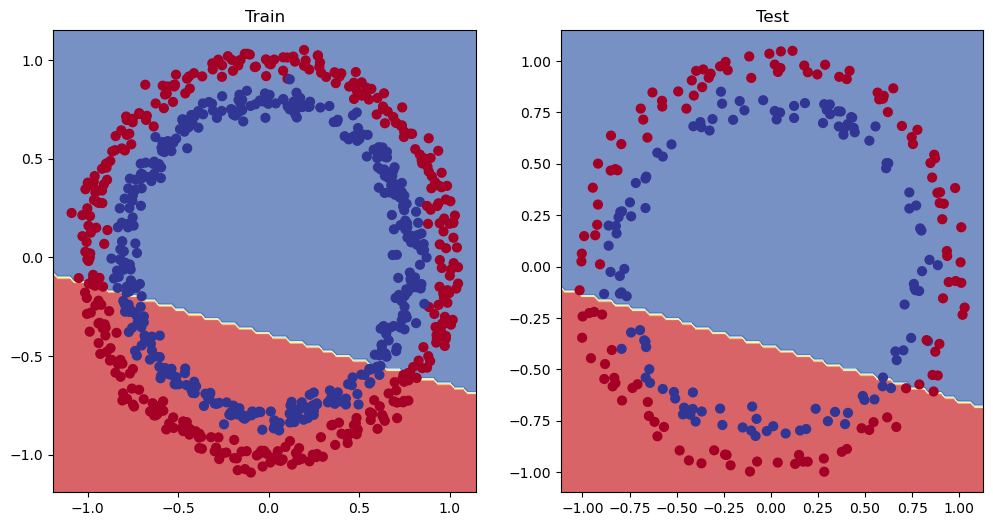

In [68]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Introducing Non Linearity (Non-Linear Model using ReLU)

## Model Definition

In [69]:
class CircleModelV2(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.model(x)

In [70]:
torch.manual_seed(MANUAL_SEED)

model_1 = CircleModelV2(2, 1, 5).to(device)
model_1

CircleModelV2(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [71]:
list(model_1.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140],
         [-0.2060, -0.0524, -0.1816,  0.2967, -0.3530],
         [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
         [ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452],
         [ 0.2764,  0.0697,  0.3613,  0.0489, -0.1410]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1202, -0.1213,  0.1882,  0.3993,  0.2585], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1955,  0.2582,  0.0800,  0.2271, -0.2726]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.4427], device='cuda:0', requires_grad=T

In [72]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [73]:
# X_train = torch.from_numpy(X_train).type(torch.float).to(device)
# y_train = torch.from_numpy(y_train).type(torch.float).to(device)
# X_test = torch.from_numpy(X_test).type(torch.float).to(device)
# y_test = torch.from_numpy(y_test).type(torch.float).to(device)

## Pre-train predictions

In [74]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)
y_logits[:5]    # Wx

tensor([[-0.5320],
        [-0.5401],
        [-0.4637],
        [-0.5528],
        [-0.4633]], device='cuda:0')

In [75]:
y_preds = torch.round(torch.sigmoid(y_logits.squeeze()))  # y_logits(Wx) -> y_pred_probs(sigmoid) -> y_preds(round)
y_preds[:5]

tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [76]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

## Loss function and Optimizer

In [77]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.3)

## Training Loop

In [78]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f},  | Test Loss: {test_loss:.5f}, ")

Epoch: 0 | Loss: 0.72399,  | Test Loss: 0.70601, 
Epoch: 100 | Loss: 0.68559,  | Test Loss: 0.68829, 
Epoch: 200 | Loss: 0.67004,  | Test Loss: 0.67344, 
Epoch: 300 | Loss: 0.63263,  | Test Loss: 0.63416, 
Epoch: 400 | Loss: 0.69218,  | Test Loss: 0.56365, 
Epoch: 500 | Loss: 0.54918,  | Test Loss: 0.55551, 


Epoch: 600 | Loss: 0.50610,  | Test Loss: 0.52186, 
Epoch: 700 | Loss: 0.46924,  | Test Loss: 0.49046, 
Epoch: 800 | Loss: 0.43973,  | Test Loss: 0.46978, 
Epoch: 900 | Loss: 0.41083,  | Test Loss: 0.45077, 
Epoch: 1000 | Loss: 0.39960,  | Test Loss: 0.45472, 
Epoch: 1100 | Loss: 0.36222,  | Test Loss: 0.43039, 
Epoch: 1200 | Loss: 0.38804,  | Test Loss: 0.47165, 
Epoch: 1300 | Loss: 0.24555,  | Test Loss: 0.29858, 
Epoch: 1400 | Loss: 0.16714,  | Test Loss: 0.23934, 
Epoch: 1500 | Loss: 0.17678,  | Test Loss: 0.27659, 
Epoch: 1600 | Loss: 0.16610,  | Test Loss: 0.23477, 
Epoch: 1700 | Loss: 0.11222,  | Test Loss: 0.19842, 
Epoch: 1800 | Loss: 0.09561,  | Test Loss: 0.18838, 
Epoch: 1900 | Loss: 0.10021,  | Test Loss: 0.19389, 


## Visualize

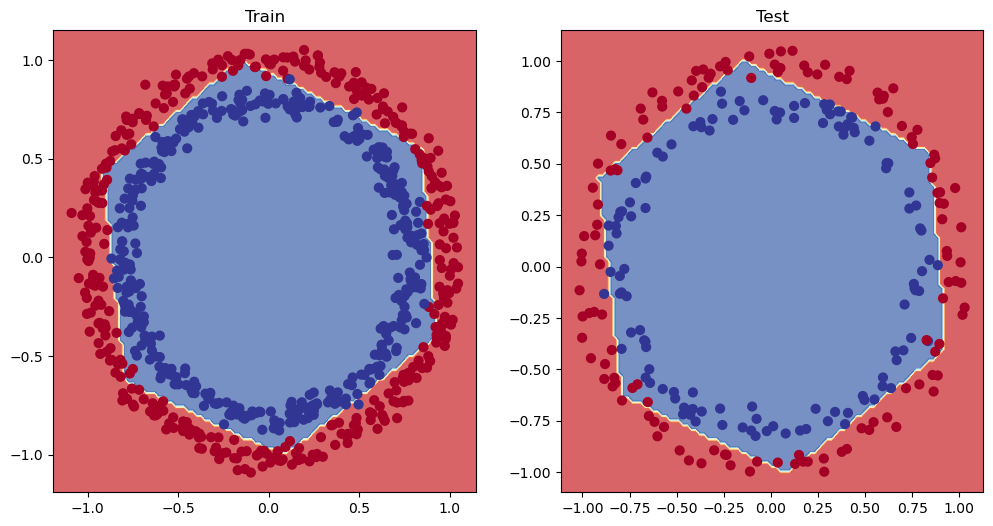

In [79]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Increasing hidden units  (Model 3)

## Model Definition

In [80]:
class CircleModelV3(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=10): # Increased hidden units
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.model(x)

In [81]:
torch.manual_seed(MANUAL_SEED)

model_2 = CircleModelV3(2, 1, 10).to(device) # Instantiate with increased hidden units
model_2

CircleModelV3(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

## Loss function and Optimizer

In [82]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.3) # Using the same learning rate as before

## Training Loop

In [83]:
# Fit the model
torch.manual_seed(42)
epochs = 2000 # Keeping the same number of epochs

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f},  | Test Loss: {test_loss:.5f}, ")

Epoch: 0 | Loss: 0.69286,  | Test Loss: 0.69332, 
Epoch: 100 | Loss: 0.68788,  | Test Loss: 0.68787, 
Epoch: 200 | Loss: 0.67502,  | Test Loss: 0.67528, 
Epoch: 300 | Loss: 0.62485,  | Test Loss: 0.62977, 
Epoch: 400 | Loss: 0.39050,  | Test Loss: 0.42717, 
Epoch: 500 | Loss: 0.38457,  | Test Loss: 0.41446, 


Epoch: 600 | Loss: 0.17927,  | Test Loss: 0.19529, 
Epoch: 700 | Loss: 0.06697,  | Test Loss: 0.11686, 
Epoch: 800 | Loss: 0.04482,  | Test Loss: 0.08865, 
Epoch: 900 | Loss: 0.03477,  | Test Loss: 0.07576, 
Epoch: 1000 | Loss: 0.02925,  | Test Loss: 0.06926, 
Epoch: 1100 | Loss: 0.02560,  | Test Loss: 0.06528, 
Epoch: 1200 | Loss: 0.02297,  | Test Loss: 0.06261, 
Epoch: 1300 | Loss: 0.02096,  | Test Loss: 0.06102, 
Epoch: 1400 | Loss: 0.01939,  | Test Loss: 0.05972, 
Epoch: 1500 | Loss: 0.01812,  | Test Loss: 0.05878, 
Epoch: 1600 | Loss: 0.01706,  | Test Loss: 0.05812, 
Epoch: 1700 | Loss: 0.01617,  | Test Loss: 0.05766, 
Epoch: 1800 | Loss: 0.01538,  | Test Loss: 0.05735, 
Epoch: 1900 | Loss: 0.01469,  | Test Loss: 0.05708, 


## Visualize results after increasing hidden units

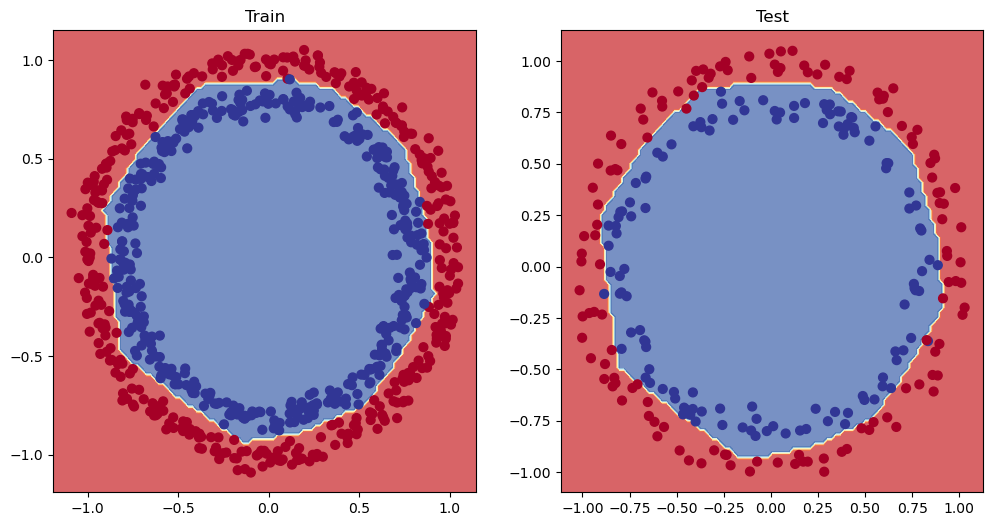

In [84]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# Binary Classification With BCELoss

In [85]:
class CircleModelV4(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=10):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [86]:
torch.manual_seed(42)

model_4= CircleModelV4(2, 1, 10).to(device)
model_4

CircleModelV4(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [87]:
list(model_4.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 

In [88]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [89]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr=0.5)

In [90]:
torch.round(model_4(X_test[:5]))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [91]:
torch.manual_seed(42)
epochs = 2000

# Put data on the same device as the model
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

  # Setting the model to train mode
  model_4.train()

  # Forward pass
  y_pred_probs = model_4(X_train).squeeze()
  y_preds = torch.round(y_pred_probs)

  # Loss calcualtion
  loss = loss_fn(y_pred_probs, y_train)

  # Clearing past gradients
  optimizer.zero_grad()

  # Backpropogation
  loss.backward()

  # Computing gradients and updating weights
  optimizer.step()

  # Validation step
  model_4.eval()
  with torch.inference_mode():
    test_pred_probs = model_4(X_test).squeeze()
    test_preds = torch.round(test_pred_probs)

    if epoch % 1000 == 0:
      print(f'Epoch {epoch} | Loss: {loss},  Test Loss: {loss_fn(test_pred_probs, y_test)}')

Epoch 0 | Loss: 0.6928612589836121,  Test Loss: 0.6931969523429871


Epoch 1000 | Loss: 0.018117116764187813,  Test Loss: 0.05532848462462425


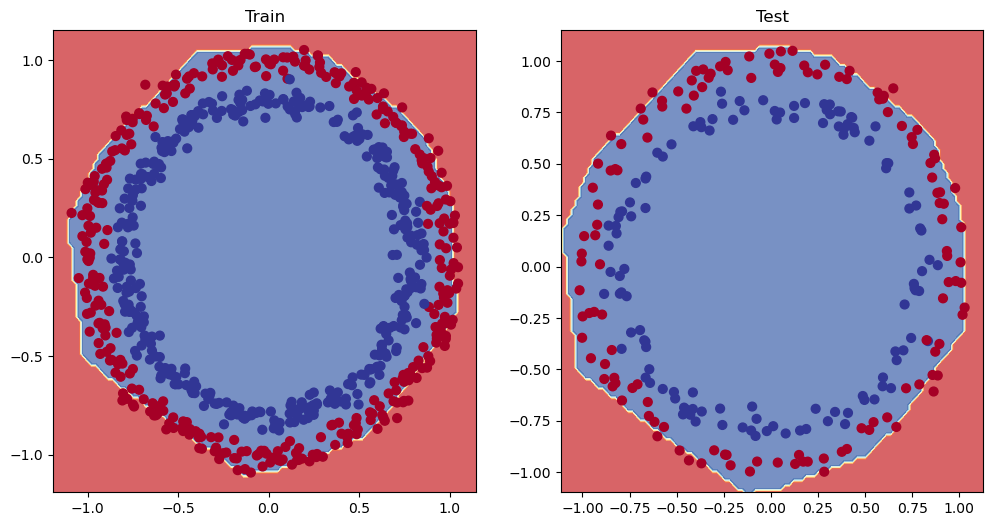

In [92]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)